In [ ]:
!pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user
!jupyter nbextension enable --py widgetsnbextension && jupyter nbextension enable --py --sys-prefix widgetsnbextension && jupyter nbextension enable --py autocomplete

In [2]:
import keras
from keras.models import Model
from keras.layers import *
from keras.applications.vgg19 import VGG19, preprocess_input
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [3]:
IMAGE_SHAPE = (400, 400, 3)

CONTENT_IMAGE = "Content.jpg"
STYLE_IMAGE = "Style.jpg"

### Loading and Processing the Images

In [4]:
# Loading and preprocessing image before sending it to VGG19
def preprocess_image(image_path):
    img = plt.imread(image_path)
    img = tf.image.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1])).numpy()
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return tf.convert_to_tensor(img)

# Deprocessing preprocessed image to display it
def deprocess_image(x):
    x = np.array(x)

    # Undoing the process made in vgg19.preprocess_input()
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [5]:
content_img = preprocess_image(CONTENT_IMAGE)
style_img = preprocess_image(STYLE_IMAGE)
combination_img = tf.Variable(preprocess_image(CONTENT_IMAGE))

### Testing the Images

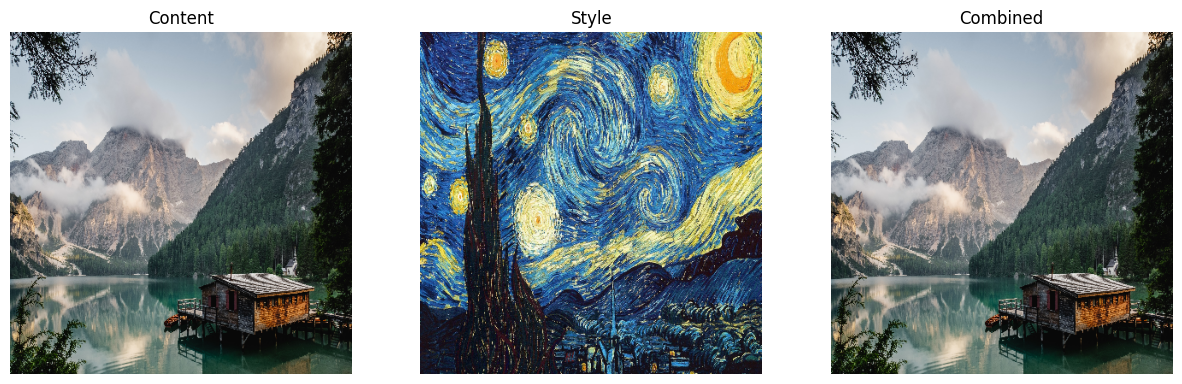

In [6]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(deprocess_image(content_img[0]))
ax[0].set_title('Content')
ax[0].axis('off');
ax[1].imshow(deprocess_image(style_img[0]))
ax[1].set_title('Style')
ax[1].axis('off');
ax[2].imshow(deprocess_image(combination_img[0]))
ax[2].set_title('Combined')
ax[2].axis('off');

### Layers will be used

In [7]:
# Layers used for Style Loss
style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
# Layer used for Content Loss
content_layer = "block5_conv2"

# Total layers used for losses
layers = style_layers.copy()
layers.append(content_layer)

### VGG19 Model

In [8]:
base = VGG19(weights="imagenet", include_top=False, input_shape=IMAGE_SHAPE)
output_layers = [base.get_layer(name).output for name in layers]

model =  Model(inputs=base.input, outputs=output_layers)
model.trainable = False

### Optimizer and Loss Functions

In [9]:
C_WEIGHT = 1.0
S_WEIGHT = 1000.0
V_WEIGHT = 10
LR = 1.0

# Optimizer
opt = keras.optimizers.Adam(learning_rate=LR)

# Style Loss
def style_loss(style, combination):
    def gram_matrix(x):
        features = tf.reshape(x, (-1, x.shape[-1]))
        return tf.matmul(features, features, transpose_a=True)

    return keras.losses.MeanSquaredError()(gram_matrix(style), gram_matrix(combination))

# Variation Loss
def variation_loss(combination):
    return tf.reduce_sum(tf.image.total_variation(combination))

# Content Loss
def content_loss(content, combination):
    return keras.losses.MeanSquaredError()(content, combination)

# Total Loss
@tf.function
def loss_function(content_image, style_image, combination_image):
    input_tensor = tf.concat([content_image, style_image, combination_image], axis=0)
    features = model(input_tensor)

    # Calculating Content Loss
    content_layer = features[5]
    content_features = content_layer[0, :, :, :]
    combination_features = content_layer[2, :, :, :]
    c_loss = C_WEIGHT * content_loss(content_features, combination_features)

    # Calculating Style Loss
    s_loss = 0.0
    for i in range(len(style_layers)):
        style_layer = features[i]
        style_features = style_layer[1, :, :, :]
        combination_features = style_layer[2, :, :, :]
        s_loss += S_WEIGHT * style_loss(style_features, combination_features)

    # Calculating Variation Loss
    v_loss = V_WEIGHT * variation_loss(combination_image)
    return c_loss + s_loss + v_loss


### Training

In [ ]:
EPOCHS = 2000

for i in range(EPOCHS):
    with tf.GradientTape() as tape:
        # Calculating loss
        loss = loss_function(content_img, style_img, combination_img)

    # Calculating gradients and applying them
    grads = tape.gradient(loss, combination_img)
    opt.apply_gradients([(grads, combination_img)])

    # Printing the process
    if i%100 == 0:
        tf.print(i, loss)

### Testing the Model


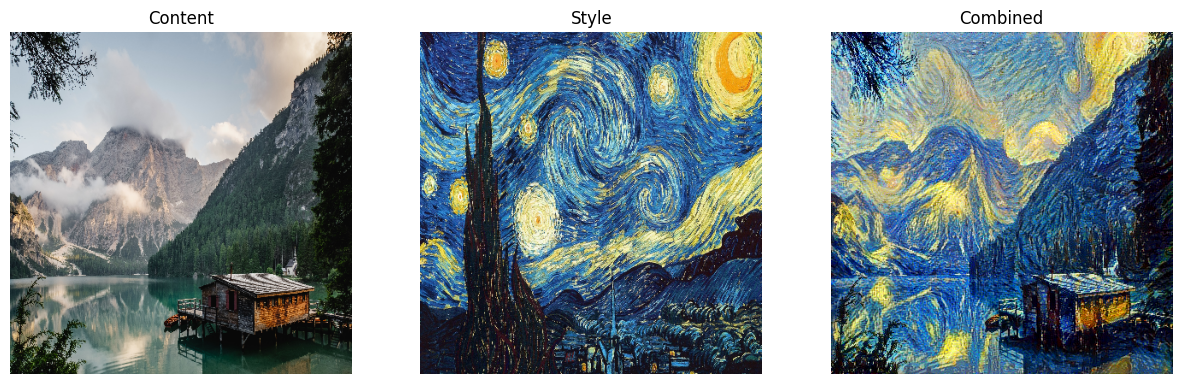

In [11]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(deprocess_image(content_img[0]))
ax[0].set_title('Content')
ax[0].axis('off');
ax[1].imshow(deprocess_image(style_img[0]))
ax[1].set_title('Style')
ax[1].axis('off');
ax[2].imshow(deprocess_image(combination_img[0]))
ax[2].set_title('Combined')
ax[2].axis('off');